In [55]:
"""This module saves different visualizations in bld / figures."""

'This module saves different visualizations in bld / figures.'

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from frechet_fda.config import SRC, BLD
from frechet_fda.tools.data_generation_tools import (
    make_truncnorm_pdf,
    gen_params_scenario_one,
    gen_predictor_values_regression,
    gen_params_regression,
    gen_y_qf
)
from frechet_fda.tools.fda_tools import (
    compute_mean_and_centered_data,
    compute_cov_function,
    compute_principal_components,
    compute_fpc_scores,
    mode_of_variation,
    gen_qdtransformation_pcs,
    karhunen_loeve
)
from frechet_fda.tools.frechet_tools import solve_frechet_qp
from frechet_fda.tools.function_tools import (
    get_optimal_range,
    frechet_mean,
    make_function_objects,
    log_qd_transform,
    inverse_log_qd_transform,
    pdf_to_qdf,
    mean_func
)


# Load saved results from simulations

In [57]:
# Save the dictionary using pickle
fda_path_pickle = SRC / "sim_results" / "stored_fda_arrays.pkl"
frechet_path_pickle = SRC / "sim_results" / "stored_ise_arrays.pkl"

with open(fda_path_pickle, "rb") as handle:
    means_and_kh_dict = pickle.load(handle)
with open(frechet_path_pickle, "rb") as handle:
    ise = pickle.load(handle)

# FDA plots

## Set up directories where to save figures

In [58]:
fda_figures = BLD / "figures" / "fda"
frechet_figures = BLD / "figures" / "frechet"
directories = {
    "broken_qdf" : fda_figures / "broken_qdf.pgf",
    "fixed_qdf" : fda_figures / "fixed_qdf.pgf",
    "naive_trunc_rep_vs_orig" : fda_figures / "naive_trunc_rep_vs_orig.pgf",
    "trunc_rep_vs_orig" : fda_figures / "trunc_rep_vs_orig.pgf",
    "1st_modes" : fda_figures / "1st_modes.pgf",
    "2nd_modes" : fda_figures / "2nd_modes.pgf",
    "frechet_means" : fda_figures / "frechet_means.pgf",
    "comparison_f_cs": fda_figures / "comparison_f_cs.pgf",
    "f_mean_vs_denstimation" : fda_figures / "f_mean_vs_denstimation.pgf",
    "cs_mean_vs_denstimation" : fda_figures / "cs_mean_vs_denstimation.pgf",
    "k_opt_histogram" : fda_figures / "k_opt_histogram.pgf",
    "k_opt_denstimation_histogram" : fda_figures / "k_opt_denstimation_histogram.pgf",
    "fve" : fda_figures / "fve.pgf",
    "fve_denstimation" : fda_figures / "fve_denstimation.pgf",
    "fve_both" : fda_figures / "fve_both.pgf",

    "1stlastqf" : frechet_figures / "1stlastqf.pgf",
    "some_densities" : frechet_figures / "some_densities.pgf",
    "frechet_estimates" : frechet_figures / "frechet_estimates.pgf",
    "frechet_estimates_3d" : frechet_figures / "frechet_estimates_3d.pgf",
    "all_observations_3d" : frechet_figures / "all_observations_3d.pgf",
    "betas" : frechet_figures / "betas.pgf",
    "beta0vsmean" : frechet_figures / "beta0vsmean.pgf",
    "func_est_vs_true" : frechet_figures / "func_est_vs_true.pgf",
    "frechet_est_vs_true" : frechet_figures / "frechet_est_vs_true.pgf",
    "ise_frechet" : frechet_figures / "ise_frechet.pgf",
    "ise_frechet_denstimation" : frechet_figures / "ise_frechet_denstimation.pgf",
    "ise_func_reg" : frechet_figures / "ise_func_reg.pgf",
    "ise_func_reg_denstimation" : frechet_figures / "ise_func_reg_denstimation.pgf",
    "ise_func_reg_both" : frechet_figures / "ise_func_reg_both.pgf",
}
for filepath in directories.values():
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)

## Some examples for FDA methods with densities

In [59]:
# Set parameters
test_n = 200
test_grid_size = 2000
test_trunc = 3
test_seed = 28071995
test_mus, test_sigmas = gen_params_scenario_one(test_n, seed=test_seed)
# Sort sigmas just for inspection reasons
test_sigmas.sort()

In [60]:
# Generate pdfs within truncation points
test_pdfs = make_truncnorm_pdf(
    -test_trunc, test_trunc, test_mus, test_sigmas, grid_size=test_grid_size, warn_irregular_densities=False
)
# Make lists of Function class objects
test_my_pdfs = make_function_objects(test_pdfs)
test_my_cdfs = [pdf.integrate() for pdf in test_my_pdfs]
test_my_qfs = [cdf.invert() for cdf in test_my_cdfs]
test_my_qdfs = [qf.differentiate() for qf in test_my_qfs]
# For numerical correction: shorten the range for smaller sigmas to get rid of
# numerical artifacts when computing integrals, derivatives and means later
test_new_ranges = get_optimal_range(test_my_pdfs)
# Generate pdfs again, this time within individual ranges
test_pdfs2 = [
    make_truncnorm_pdf(
        test_new_ranges[i][0],
        test_new_ranges[i][1],
        test_mus[i],
        test_sigmas[i],
        grid_size=test_grid_size,
        warn_irregular_densities=False,
    )[0]
    for i in range(test_n)
]
test_new_pdfs = make_function_objects(test_pdfs2)

C:\Coding\frechet_fda\src\frechet_fda\tools\numerics_tools.py:62: RuntimeWarning: divide by zero encountered in divide
  d_y[:-1] = np.diff(y_vals) / np.diff(d_x)


In [61]:
# Choose bad qdf
smallest_sigma = test_sigmas.argmin()

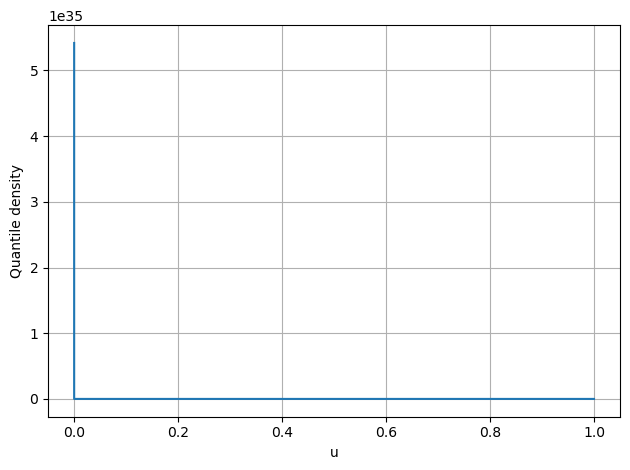

In [62]:
# PLot broken qdf
fig, ax = plt.subplots()
ax.plot(
    test_my_qdfs[smallest_sigma].x,
    test_my_qdfs[smallest_sigma].y,
)
plt.xlabel("u")
plt.ylabel("Quantile density")
# plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["broken_qdf"], format='pgf', dpi=1200)
# Show it
plt.show()

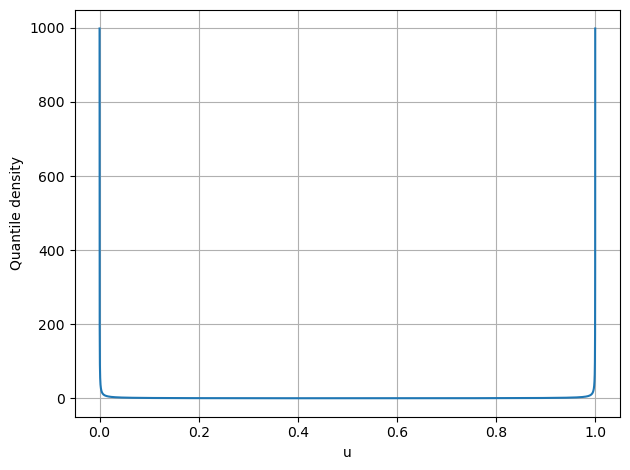

In [63]:
# Plot fixed qdf
fig, ax = plt.subplots()
ax.plot(
    pdf_to_qdf(test_new_pdfs[smallest_sigma]).x,
    pdf_to_qdf(test_new_pdfs[smallest_sigma]).y,
)
plt.xlabel("u")
plt.ylabel("Quantile density")
# plt.legend()
plt.grid()
plt.tight_layout()
# Save the figure
plt.savefig(directories["fixed_qdf"], format='pgf', dpi=1200)
# Show it
plt.show()

In [64]:
naive_mean_pdf, naive_centered_pdfs = compute_mean_and_centered_data(test_new_pdfs)
test_covariance_function = compute_cov_function(naive_centered_pdfs)
naive_eigenvalues, naive_eigenfunctions = compute_principal_components(
    naive_centered_pdfs[0].x,
    test_covariance_function,
)
naive_fpc_scores = compute_fpc_scores(naive_centered_pdfs[0].x, naive_centered_pdfs, naive_eigenfunctions)

In [65]:
naive_kh_reps1 = karhunen_loeve(
    naive_mean_pdf,
    naive_eigenvalues,
    naive_fpc_scores,
    K=1,
)
naive_kh_reps2 = karhunen_loeve(
    naive_mean_pdf,
    naive_eigenvalues,
    naive_fpc_scores,
    K=2,
)

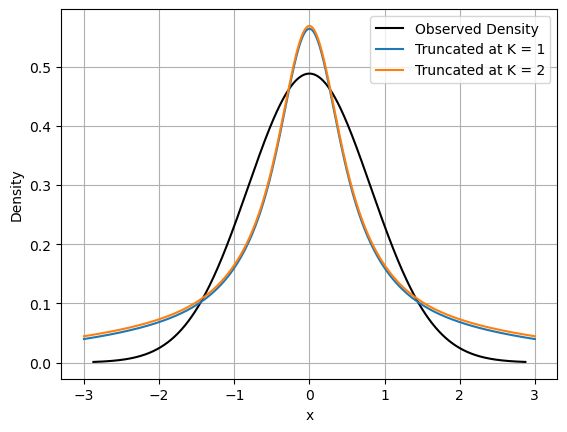

In [75]:
# Trunc representations vs observed density
test_pdf_of_interest = 90
fig, ax = plt.subplots()
ax.plot(
    test_new_pdfs[test_pdf_of_interest].x,
    test_new_pdfs[test_pdf_of_interest].y,
    label="Observed Density",
    color="black",
)
ax.plot(
    naive_kh_reps1[test_pdf_of_interest].x,
    naive_kh_reps1[test_pdf_of_interest].y,
    label=f"Truncated at K = 1",
)
ax.plot(
    naive_kh_reps2[test_pdf_of_interest].x,
    naive_kh_reps2[test_pdf_of_interest].y + 0.005,
    label=f"Truncated at K = 2",
)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["naive_trunc_rep_vs_orig"], format='pgf', dpi=1200)
# Show it
plt.show()

In [67]:
naive_mode_of_variation1 = mode_of_variation(
    naive_mean_pdf, naive_eigenvalues[0], naive_eigenfunctions[0], 1
)
naive_mode_of_variation2 = mode_of_variation(
    naive_mean_pdf, naive_eigenvalues[1], naive_eigenfunctions[1], 1
)

### Transformation FPCA

In [68]:
test_log_qdfs = log_qd_transform(test_new_pdfs)
# Compute transformation FPCA objects
test_pcs_to_compute = 15
(
    test_mean_log_qdfs,
    test_eigenvalues_log_qdfs,
    test_eigenfunctions_log_qdfs,
    test_fpc_scores_log_qdfs,
) = gen_qdtransformation_pcs(test_log_qdfs, k=test_pcs_to_compute)

In [69]:
# Karhunen-Loève decomposition of transforms
test_truncated_representations_transforms1 = karhunen_loeve(
    test_mean_log_qdfs,
    test_eigenfunctions_log_qdfs,
    test_fpc_scores_log_qdfs,
    K=1,
)
test_truncated_representations_transforms2 = karhunen_loeve(
    test_mean_log_qdfs,
    test_eigenfunctions_log_qdfs,
    test_fpc_scores_log_qdfs,
    K=2,
)
# Transform to density space. Compare truncated representation against real density
test_truncated_representations1 = inverse_log_qd_transform(
    test_truncated_representations_transforms1,
)
test_truncated_representations2 = inverse_log_qd_transform(
    test_truncated_representations_transforms2,
)

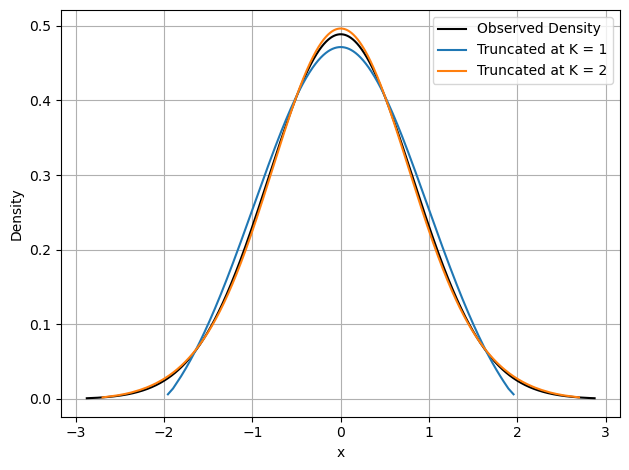

In [70]:
# Trunc representations vs observed density
test_pdf_of_interest = 90
fig, ax = plt.subplots()
ax.plot(
    test_new_pdfs[test_pdf_of_interest].x,
    test_new_pdfs[test_pdf_of_interest].y,
    label="Observed Density",
    color="black",
)
ax.plot(
    test_truncated_representations1[test_pdf_of_interest].x,
    test_truncated_representations1[test_pdf_of_interest].y,
    label=f"Truncated at K = 1",
)
ax.plot(
    test_truncated_representations2[test_pdf_of_interest].x,
    test_truncated_representations2[test_pdf_of_interest].y,
    label=f"Truncated at K = 2",
)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["trunc_rep_vs_orig"], format='pgf', dpi=1200)
# Show it
plt.show()

In [17]:
# Modes of variation
test_variation_modes_transforms = [
    mode_of_variation(test_mean_log_qdfs, eigval, eigfunc, alpha=1)
    for eigval, eigfunc
    in zip(test_eigenvalues_log_qdfs, test_eigenfunctions_log_qdfs, strict=True)
]
# Translate modes of variation to density space, compare first two modes
test_variation_modes = inverse_log_qd_transform(test_variation_modes_transforms)

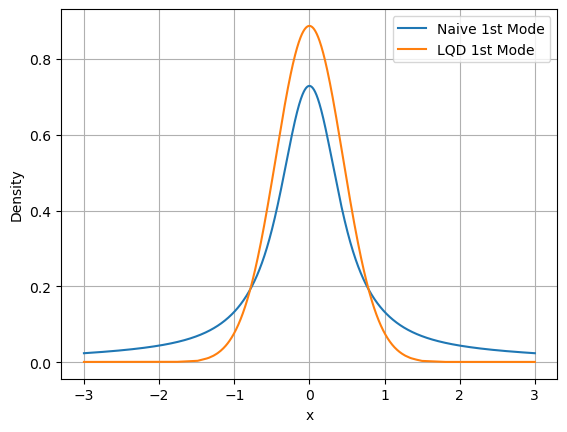

In [18]:
first_transformed_mode = test_variation_modes[0].warp_range(-test_trunc, test_trunc)

# Naive vs Transformed modes of variation
fig, ax = plt.subplots()
ax.plot(
    naive_mode_of_variation1.x,
    naive_mode_of_variation1.y,
    label=f"Naive 1st Mode",
)
ax.plot(
    first_transformed_mode.x,
    first_transformed_mode.y,
    label=f"LQD 1st Mode",
)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["1st_modes"], format='pgf', dpi=1200)
# Show it
plt.show()

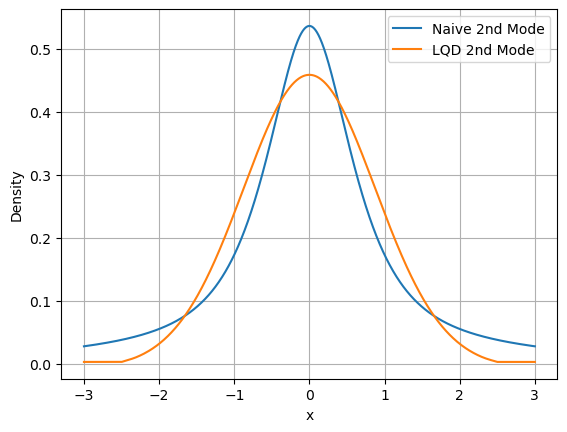

In [19]:
second_transformed_mode = test_variation_modes[1].warp_range(-test_trunc, test_trunc)

# Naive vs Transformed modes of variation
fig, ax = plt.subplots()
ax.plot(
    naive_mode_of_variation2.x,
    naive_mode_of_variation2.y,
    label=f"Naive 2nd Mode",
)
ax.plot(
    second_transformed_mode.x,
    second_transformed_mode.y,
    label=f"LQD 2nd Mode",
)
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["2nd_modes"], format='pgf', dpi=1200)
# Show it
plt.show()

## Load simulation parameters

In [20]:
# Number of simulations
fda_sim_m = 500
# Number of samples of densities to generate
fda_sim_sample_sizes = [50, 100, 200]
# Number of sample points to generate from each density for density estimation step
fda_sim_points_number = 100
# Bandwidth choice for density estimation
fda_sim_bandwidth_choice = 0.2
# Fineness of grids to evaluate functions
fda_sim_grid_size = 1000
# Where to truncate normal distribution
fda_sim_trunc = 3
# Choose how many FPCS to compute. Maximum: fda_sim_grid_size
fda_sim_how_many_fpcs = 10
# How much variance to be explained for cutoff in KH-representation
fda_sim_threshold_variance_explained = 0.9
# Whether to compute Wasserstein-Fréchet means artifically centered on zero
fda_sim_centered_on_zero = False

In [21]:
# Calculate true center of distribution for plotting against estimates
std_normal = make_truncnorm_pdf(-fda_sim_trunc, fda_sim_trunc, 0, 1, grid_size=fda_sim_grid_size)[0]

C:\Coding\frechet_fda\src\frechet_fda\tools\data_generation_tools.py:258: UserWarning: Not all provided densities integrate to 1 with tolerance 1e-05!
 Max case of deviation is: 1.4175481690248404e-05
 In position: 0
 Performing normalization...
  warnings.warn(


In [22]:
stored_f_means = means_and_kh_dict["stored_means_frechet"]
stored_cs_means = means_and_kh_dict["stored_means_cs"]
stored_f_means_denstimation = means_and_kh_dict["stored_means_frechet_denstimation"]
stored_cs_means_denstimation = means_and_kh_dict["stored_means_cs_denstimation"]

stored_k_opt = means_and_kh_dict["stored_k_opt"]
stored_fve = means_and_kh_dict["stored_fve"]
stored_k_opt_denstimation = means_and_kh_dict["stored_k_opt_denstimation"]
stored_fve_denstimation = means_and_kh_dict["stored_fve_denstimation"]

In [23]:
# Calculate Fréchet means of Fréchet means over all simulations; standardize their range
# to [-3,3] by linear interpolation because uncertatinty from estimation of support
# start leads them out of support
mean_of_f_means50 = frechet_mean(stored_f_means[:, 0], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_f_means100 = frechet_mean(stored_f_means[:, 1], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_f_means200 = frechet_mean(stored_f_means[:, 2], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_cs_means50 = frechet_mean(stored_cs_means[:, 0], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_cs_means100 = frechet_mean(stored_cs_means[:, 1], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_cs_means200 = frechet_mean(stored_cs_means[:, 2], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_f_means50_denstimation = frechet_mean(stored_f_means_denstimation[:, 0], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_f_means100_denstimation = frechet_mean(stored_f_means_denstimation[:, 1], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_f_means200_denstimation = frechet_mean(stored_f_means_denstimation[:, 2], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_cs_means50_denstimation = frechet_mean(stored_cs_means_denstimation[:, 0], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_cs_means100_denstimation = frechet_mean(stored_cs_means_denstimation[:, 1], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)
mean_of_cs_means200_denstimation = frechet_mean(stored_cs_means_denstimation[:, 2], centered_on_zero=fda_sim_centered_on_zero).warp_range(-fda_sim_trunc, fda_sim_trunc)

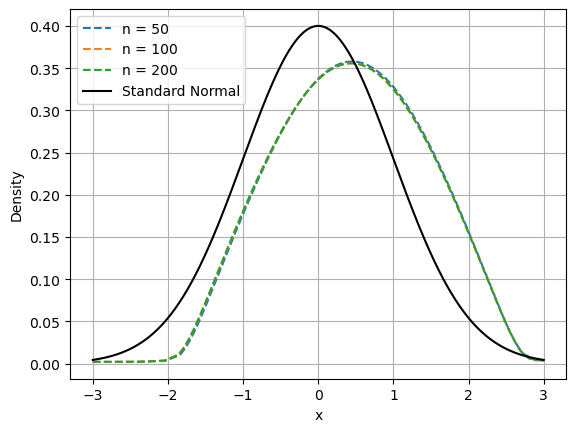

In [24]:
# Plot Fréchet means of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(mean_of_f_means50.x, mean_of_f_means50.y, label="n = 50", linestyle="--")
ax.plot(mean_of_f_means100.x, mean_of_f_means100.y, label="n = 100", linestyle="--")
ax.plot(mean_of_f_means200.x, mean_of_f_means200.y, label="n = 200", linestyle="--")
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["frechet_means"], format='pgf', dpi=1200)
# Show it
plt.show()

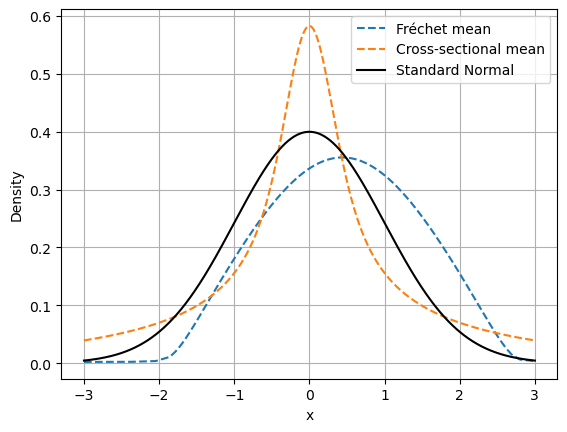

In [25]:
# Plot Fréchet mean vs cross-sectional mean and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x, mean_of_f_means200.y, label="Fréchet mean", linestyle="--",
)
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="Cross-sectional mean",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["comparison_f_cs"], format='pgf', dpi=1200)
# Show it
plt.show()

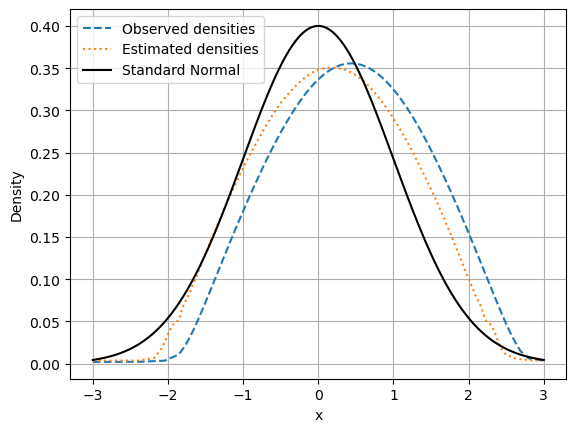

In [26]:
# Plot Fréchet mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x,
    mean_of_f_means200.y,
    label="Observed densities",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Estimated densities",
    linestyle="dotted",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["f_mean_vs_denstimation"], format='pgf', dpi=1200)
# Show it
plt.show()

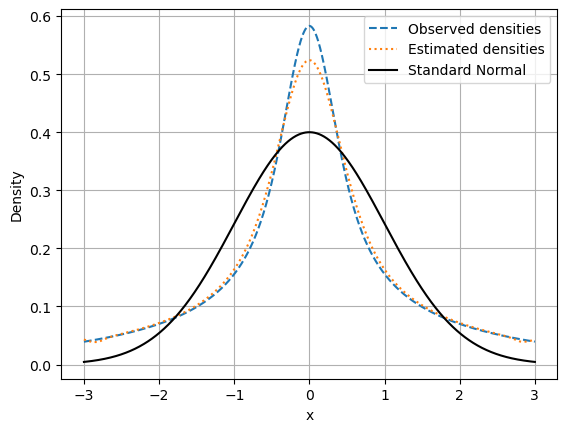

In [27]:
# Plot cross-sectional mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="Observed densities",
    linestyle="--",
)
ax.plot(
    mean_of_cs_means200_denstimation.x,
    mean_of_cs_means200_denstimation.y,
    label="Estimated densities",
    linestyle="dotted",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["cs_mean_vs_denstimation"], format='pgf', dpi=1200)
# Show it
plt.show()

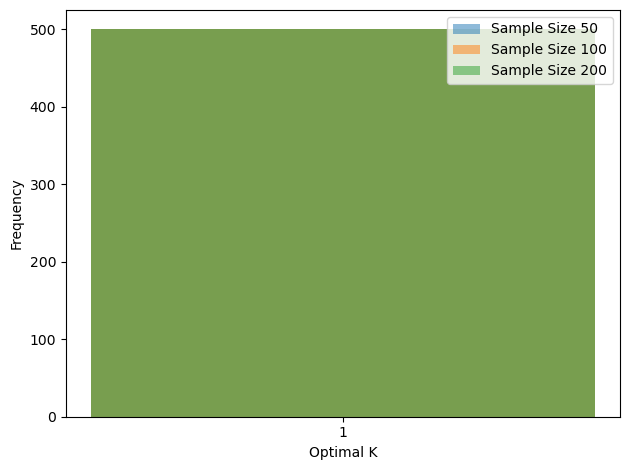

In [28]:
# UGLY PLOT; WILL NOT USE
data_of_interest = stored_k_opt

plt.subplot()

# Create histograms
for j in range(len(fda_sim_sample_sizes)):
    plt.hist(data_of_interest[:, j], bins=np.arange(0.5, np.max(data_of_interest) + 1.5), alpha=0.5, label=f"Sample Size {fda_sim_sample_sizes[j]}")

# Set x-axis ticks to represent each positive integer up to the maximum value of K
plt.xticks(np.arange(1, np.max(data_of_interest) + 1))

plt.xlabel("Optimal K")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig(directories["k_opt_histogram"], format='pgf', dpi=1200)
# Show it
plt.show()

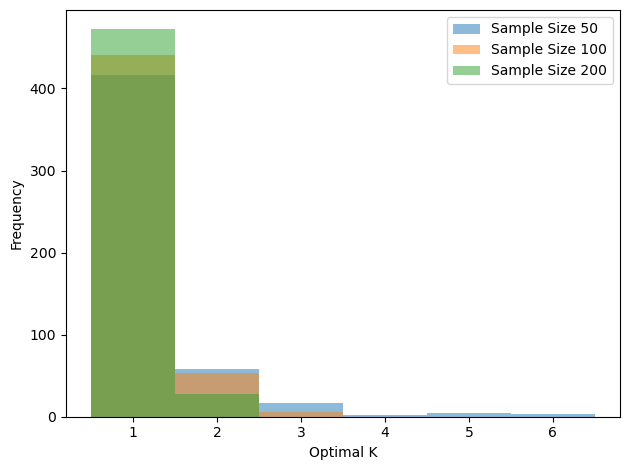

In [29]:
data_of_interest = stored_k_opt_denstimation

plt.subplot()

# Create histograms
for j in range(len(fda_sim_sample_sizes)):
    plt.hist(data_of_interest[:, j], bins=np.arange(0.5, np.max(data_of_interest) + 1.5), alpha=0.5, label=f"Sample Size {fda_sim_sample_sizes[j]}")

# Set x-axis ticks to represent each positive integer up to the maximum value of K
plt.xticks(np.arange(1, np.max(data_of_interest) + 1))

# plt.title("Optimal choice of K for reaching fve of at least 90%")
plt.xlabel("Optimal K")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig(directories["k_opt_denstimation_histogram"], format='pgf', dpi=1200)
# Show it
plt.show()

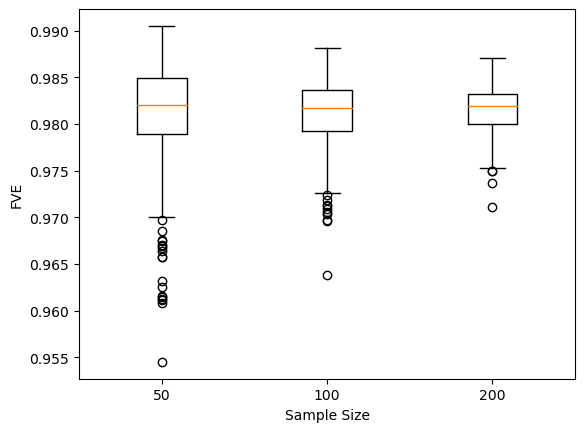

In [30]:
plt.boxplot(stored_fve, labels=["50", "100", "200"])

# plt.title("Fraction of variance explained across different sample sizes for K = 1")
plt.xlabel("Sample Size")
plt.ylabel("FVE")

# Save the figure
plt.savefig(directories["fve"], format='pgf', dpi=1200)
# Show it
plt.show()

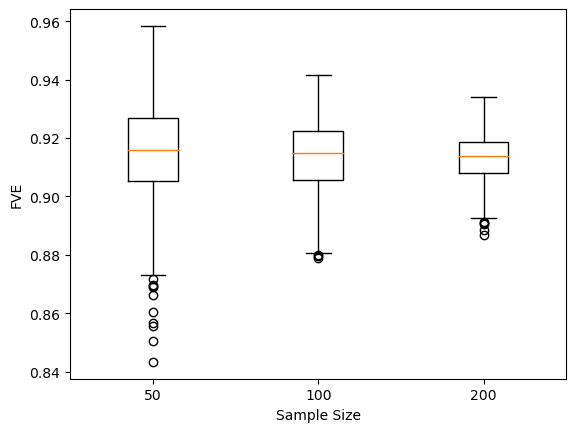

In [31]:
plt.boxplot(stored_fve_denstimation, labels=["50", "100", "200"])

# plt.title("Fraction of variance explained across different sample sizes for K = 1")
plt.xlabel("Sample Size")
plt.ylabel("FVE")

# Save the figure
plt.savefig(directories["fve_denstimation"], format='pgf', dpi=1200)
# Show it
plt.show()

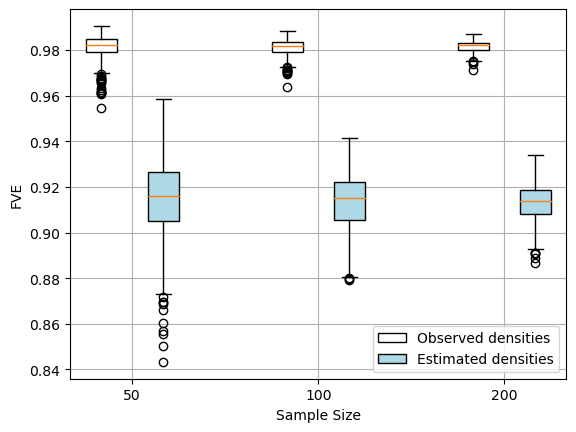

In [32]:
### NOT USED; TOO HARD TO DISTINGUISH
# Prepare the data for plotting
# For each sample size, we have two sets of data (from stored_ise_func_reg_denstimation and stored_ise_func_reg)
data_to_plot = [(stored_fve[:, i], stored_fve_denstimation[:, i]) for i in range(3)]

# Flatten the list to plot
data_to_plot = [item for sublist in data_to_plot for item in sublist]

# Create custom labels
labels = ["50", "50", "100", "100", "200", "200"]

# Create the boxplot
positions = [1, 2, 4, 5, 7, 8]
bp = plt.boxplot(data_to_plot, positions=positions, patch_artist=True)

# Adding titles and labels
# plt.title("Distribution of FVE Across Different Sample Sizes")
plt.xlabel("Sample Size")
plt.ylabel("FVE")

# Manually set tick positions and labels
tick_positions = [1.5, 4.5, 7.5]
tick_labels = ["50", "100", "200"]
plt.xticks(tick_positions, tick_labels)

# Change the color of boxes from 'denstimation' data to blue
colors = ['white', 'lightblue', 'white', 'lightblue', 'white', 'lightblue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add legend
plt.legend([bp["boxes"][0], bp["boxes"][1]], ["Observed densities", "Estimated densities"])

# Adding grid for better readability
plt.grid(True)

# Save the figure
plt.savefig(directories["fve_both"], format='pgf', dpi=1200)
# Show it
plt.show()


# Fréchet

## Some settings

In [33]:
frechet_N = 200
frechet_seed = 28071995
# Parameters for linear relation
frechet_predictor_bounds = (-1, 1)
frechet_mu_params_dict = {"mu0": 0, "beta": 4, "v1": 0.25}
frechet_sigma_params_dict = {"sigma0": 3, "gamma": 2, "v2": 2}

# Define u grid on which to evaluate function points
frechet_grid_size = 500
frechet_grid_to_predict_size = 50
frechet_delta = 0  # can start bounded away from zero and one
frechet_u = np.linspace(frechet_delta, 1 - frechet_delta, frechet_grid_size)

In [34]:
frechet_predictor_vals = gen_predictor_values_regression(frechet_N, frechet_predictor_bounds, frechet_seed)
frechet_mus, frechet_sigmas = gen_params_regression(
    frechet_mu_params_dict, frechet_sigma_params_dict, frechet_predictor_vals, frechet_seed,
)

In [35]:
frechet_x_grid = np.linspace(frechet_predictor_bounds[0], frechet_predictor_bounds[1], frechet_grid_to_predict_size)
frechet_qfs = gen_y_qf(frechet_mus, frechet_sigmas, frechet_u)
frechet_qfs = [qf.drop_inf() for qf in frechet_qfs]

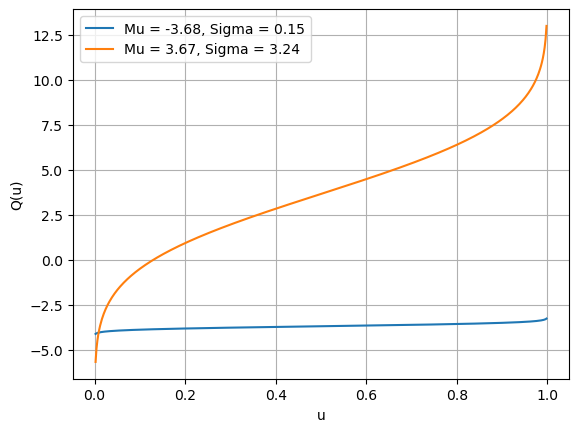

In [36]:
# Select which qfs to compare
first_qf_to_compare = 0
second_qf_to_compare = -1

first_qf = frechet_qfs[first_qf_to_compare]
last_qf = frechet_qfs[second_qf_to_compare]

# Plot
fig, ax = plt.subplots()
ax.plot(
    first_qf.x,
    first_qf.y,
    label=(
        f"Mu = {round(frechet_mus[first_qf_to_compare], 2)}, "
        f"Sigma = {round(frechet_sigmas[first_qf_to_compare], 2)}"
    ),
)
ax.plot(
    last_qf.x,
    last_qf.y,
    label=(
        f"Mu = {round(frechet_mus[second_qf_to_compare], 2)}, "
        f"Sigma = {round(frechet_sigmas[second_qf_to_compare], 2)}"
    ),
)
plt.xlabel("u")
plt.ylabel("Q(u)")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["1stlastqf"], format='pgf', dpi=1200)
# Show it
plt.show()

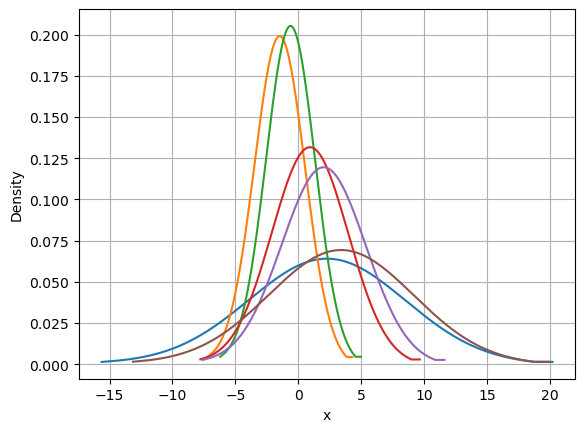

In [37]:
# Plot some densities of the generated distributions
fig, ax = plt.subplots()
frechet_some_qfs = np.random.default_rng().choice(frechet_qfs, size=6, replace=False)
for qf in frechet_some_qfs:
    pdf = qf.invert().differentiate()
    ax.plot(
        pdf.x,
        pdf.y,
    )
plt.grid()
plt.xlabel("x")
plt.ylabel("Density")
# Save the figure
plt.savefig(directories["some_densities"], format='pgf', dpi=1200)
# Show it
plt.show()

In [38]:
frechet_estimates = solve_frechet_qp(
    xs_to_predict=frechet_x_grid, x_observed=frechet_predictor_vals, quantile_functions=frechet_qfs,
)

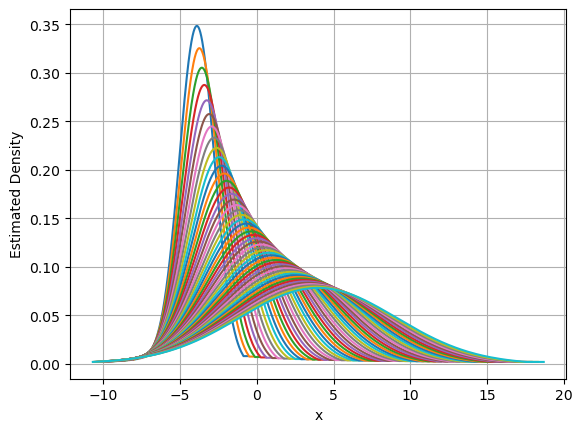

In [39]:
fig, ax = plt.subplots()
for qf in frechet_estimates:
    pdf = qf.invert().differentiate()
    plt.plot(pdf.x, pdf.y)
plt.grid()
plt.xlabel("x")
plt.ylabel("Estimated Density")
# Save the figure
plt.savefig(directories["frechet_estimates"], format='pgf', dpi=1200)
# Show it
plt.show()

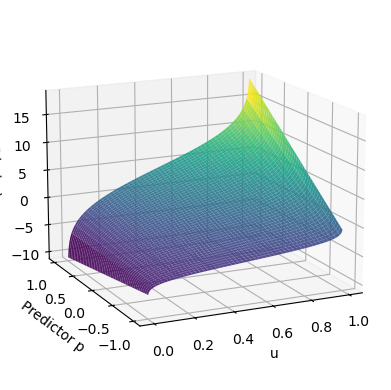

In [40]:
# Initialize a 2D array to hold f(u, x) values
frechet_z_values = np.zeros((len(frechet_x_grid), len(frechet_estimates[0].x)))

# Populate the array with estimates
for i, func in enumerate(frechet_estimates):
    frechet_z_values[i] = func.y

# Create the 3D surface plot
X, Y = np.meshgrid(frechet_estimates[0].x, frechet_x_grid)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, frechet_z_values, cmap="viridis", alpha=0.9)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=245)

ax.set_xlabel("u")
ax.set_ylabel("Predictor p")
ax.set_zlabel("Q(u | p)", rotation=0)
plt.tight_layout()
# Save the figure
plt.savefig(directories["frechet_estimates_3d"], format='pgf', dpi=1200)
# Show it
plt.show()

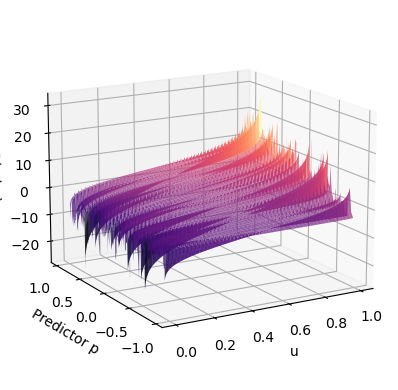

In [41]:
# Plot for all qfs, not just subset
frechet_z_values_qfs = np.zeros((len(frechet_predictor_vals), len(frechet_qfs[0].x)))
for i, func in enumerate(frechet_qfs):
    frechet_z_values_qfs[i] = func.y

# Create the 3D surface plot for 'estimates'
X, Y = np.meshgrid(frechet_qfs[0].x, frechet_predictor_vals)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")

# Create the 3D surface plot for 'qfs'
ax.plot_surface(X, Y, frechet_z_values_qfs, cmap="magma", alpha=0.7)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=240)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor p")
ax.set_zlabel("Q(u | p)", rotation=0)

plt.tight_layout()
# Save the figure
plt.savefig(directories["all_observations_3d"], format='pgf', dpi=1200)
# Show it
plt.show()

## Functional Regression with Transformation method

In [42]:
frechet_pdfs = [qf.drop_inf().invert().differentiate() for qf in frechet_qfs]
frechet_lqdfs, frechet_start_vals = log_qd_transform(frechet_pdfs, different_supports=True)
frechet_predictor_matrix = np.array((np.ones_like(frechet_predictor_vals), frechet_predictor_vals)).transpose()
frechet_log_betahat = (
    np.linalg.inv(frechet_predictor_matrix.transpose() @ frechet_predictor_matrix)
    @ frechet_predictor_matrix.transpose()
    @ frechet_lqdfs
)
frechet_log_betahat0 = frechet_log_betahat[0]
frechet_log_betahat1 = frechet_log_betahat[1]

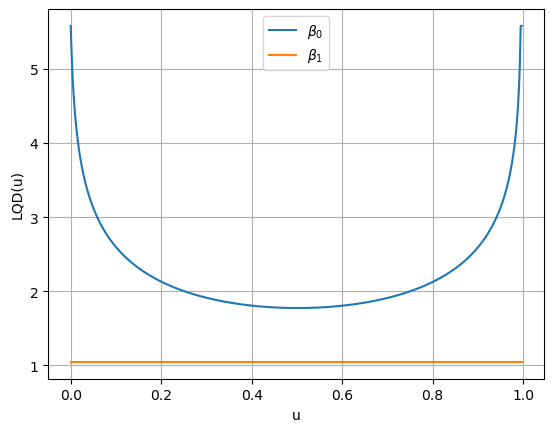

In [43]:
# Estimated betas plot
fig, ax = plt.subplots()
ax.plot(
    frechet_log_betahat0.x,
    frechet_log_betahat0.y,
    label=r"$\beta_0$",
)
ax.plot(
    frechet_log_betahat1.x,
    frechet_log_betahat1.y,
    label=r"$\beta_1$",
)
plt.xlabel("u")
plt.ylabel("LQD(u)")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["betas"], format='pgf', dpi=1200)
# Show it
plt.show()

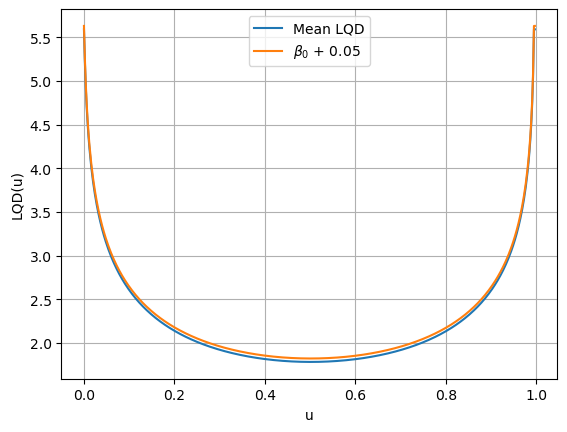

In [44]:
# See that beta0 is equal to the mean of the log qdfs
frechet_mean_lqdf = mean_func(frechet_lqdfs)
# Plot
fig, ax = plt.subplots()
ax.plot(
    frechet_mean_lqdf.x,
    frechet_mean_lqdf.y,
    label="Mean LQD",
)
ax.plot(
    frechet_log_betahat0.x,
    frechet_log_betahat0.y + 0.05,
    label=r"$\beta_0$ + 0.05",
)
plt.xlabel("u")
plt.ylabel("LQD(u)")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["beta0vsmean"], format='pgf', dpi=1200)
# Show it
plt.show()

In [45]:
frechet_lqdf_hat = frechet_x_grid * frechet_log_betahat1 + frechet_log_betahat0
frechet_interpolated_start_vals = np.interp(frechet_x_grid, frechet_predictor_vals, frechet_start_vals)
frechet_pdf_hat = inverse_log_qd_transform(frechet_lqdf_hat, frechet_interpolated_start_vals)
frechet_qf_hat = [pdf.integrate().invert() for pdf in frechet_pdf_hat]

In [46]:
frechet_true_mus = frechet_mu_params_dict["mu0"] + frechet_mu_params_dict["beta"] * frechet_x_grid
frechet_true_sigmas = frechet_sigma_params_dict["sigma0"] + frechet_sigma_params_dict["gamma"] * frechet_x_grid
frechet_true_m = gen_y_qf(frechet_true_mus, frechet_true_sigmas, frechet_u)
frechet_true_m = [qf.drop_inf() for qf in frechet_true_m]

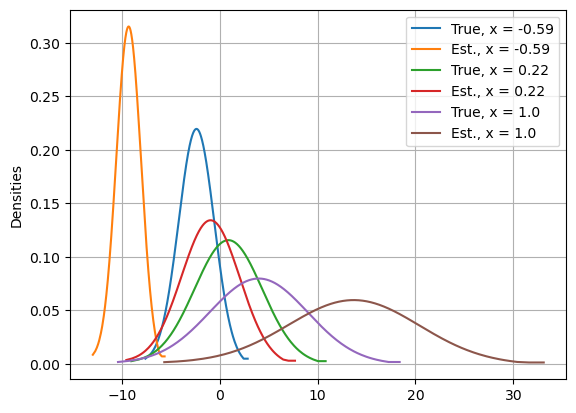

In [47]:
which_to_look_at = [10, 30, 49]
# Plot
fig, ax = plt.subplots()
for i in which_to_look_at:
    x_of_interest = round(frechet_x_grid[i], 2)
    true_qf = frechet_true_m[i]
    hat_qf = frechet_qf_hat[i]
    true_pdf = true_qf.invert().differentiate()
    hat_pdf = hat_qf.invert().differentiate()
    plt.plot(true_pdf.x, true_pdf.y, label=f"True, x = {x_of_interest}")
    plt.plot(hat_pdf.x, hat_pdf.y, label=f"Est., x = {x_of_interest}")
plt.ylabel("Densities")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["func_est_vs_true"], format='pgf', dpi=1200)
# Show it
plt.show()

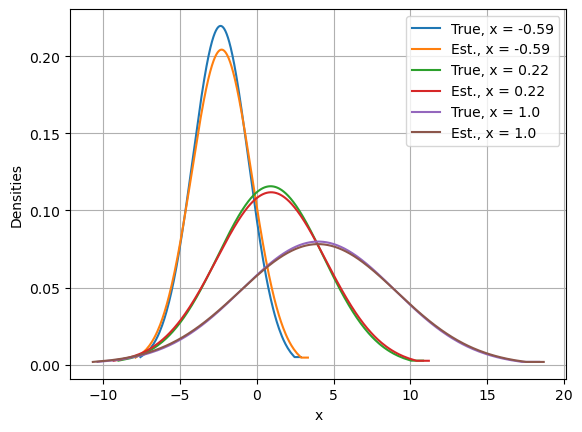

In [48]:
# Plot
fig, ax = plt.subplots()
for i in which_to_look_at:
    x_of_interest = round(frechet_x_grid[i], 2)
    true_qf = frechet_true_m[i]
    hat_qf = frechet_estimates[i]
    true_pdf = true_qf.invert().differentiate()
    hat_pdf = hat_qf.invert().differentiate()
    plt.plot(true_pdf.x, true_pdf.y, label=f"True, x = {x_of_interest}")
    plt.plot(hat_pdf.x, hat_pdf.y, label=f"Est., x = {x_of_interest}")
plt.xlabel("x")
plt.ylabel("Densities")
plt.legend()
plt.grid()
# Save the figure
plt.savefig(directories["frechet_est_vs_true"], format='pgf', dpi=1200)
# Show it
plt.show()

## Simulation plots

In [49]:
stored_ise_frechet = ise["stored_ise_frechet"]
stored_ise_func_reg = ise["stored_ise_func_reg"]
stored_ise_frechet_denstimation = ise["stored_ise_frechet_denstimation"]
stored_ise_func_reg_denstimation = ise["stored_ise_func_reg_denstimation"]

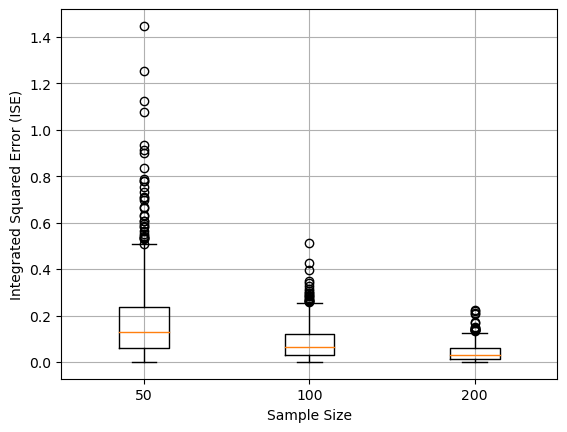

In [50]:
plt.boxplot(stored_ise_frechet, labels=["50", "100", "200"])

# plt.title("Distribution of ISE Across Different Sample Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Integrated Squared Error (ISE)")

plt.grid()
# Save the figure
plt.savefig(directories["ise_frechet"], format='pgf', dpi=1200)
# Show it
plt.show()

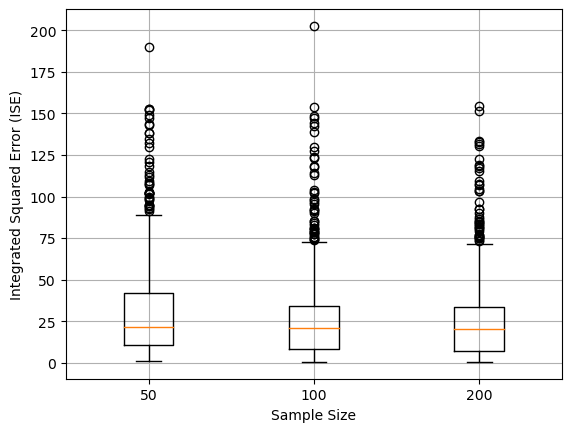

In [51]:
plt.boxplot(stored_ise_frechet_denstimation, labels=["50", "100", "200"])

# plt.title("Distribution of ISE Across Different Sample Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Integrated Squared Error (ISE)")

plt.grid()
# Save the figure
plt.savefig(directories["ise_frechet_denstimation"], format='pgf', dpi=1200)
# Show it
plt.show()

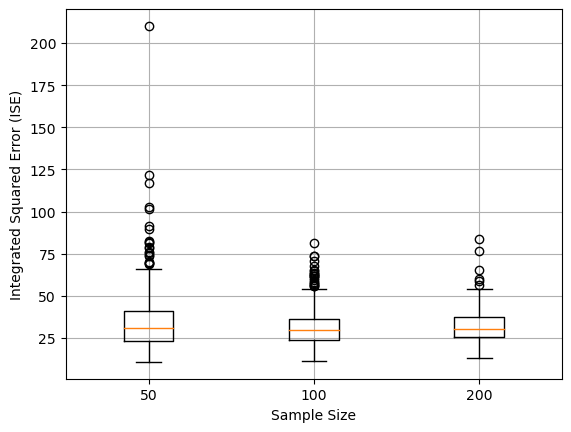

In [52]:
plt.boxplot(stored_ise_func_reg, labels=["50", "100", "200"])

# plt.title("Distribution of ISE Across Different Sample Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Integrated Squared Error (ISE)")

plt.grid()
# Save the figure
plt.savefig(directories["ise_func_reg"], format='pgf', dpi=1200)
# Show it
plt.show()

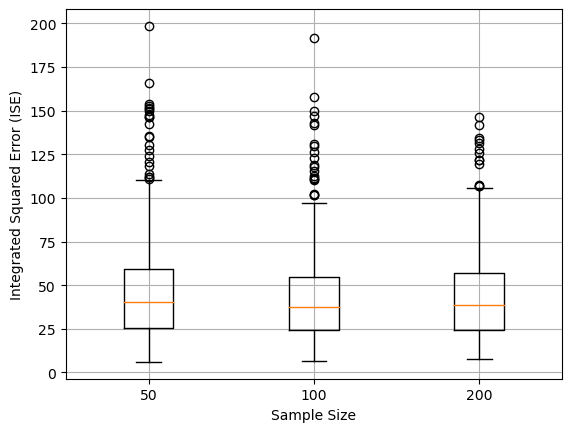

In [53]:
plt.boxplot(stored_ise_func_reg_denstimation, labels=["50", "100", "200"])

# plt.title("Distribution of ISE Across Different Sample Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Integrated Squared Error (ISE)")

plt.grid()
# Save the figure
plt.savefig(directories["ise_func_reg_denstimation"], format='pgf', dpi=1200)
# Show it
plt.show()

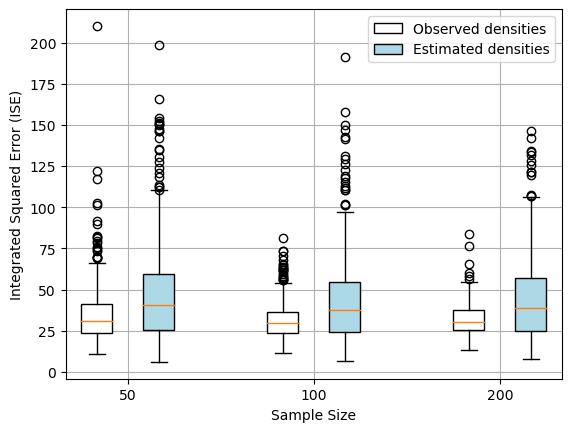

In [54]:
# Prepare the data for plotting
# For each sample size, we have two sets of data (from stored_ise_func_reg_denstimation and stored_ise_func_reg)
data_to_plot = [(stored_ise_func_reg[:, i], stored_ise_func_reg_denstimation[:, i]) for i in range(3)]

# Flatten the list to plot
data_to_plot = [item for sublist in data_to_plot for item in sublist]

# Create custom labels
labels = ["50", "50", "100", "100", "200", "200"]

# Create the boxplot
positions = [1, 2, 4, 5, 7, 8]
bp = plt.boxplot(data_to_plot, positions=positions, patch_artist=True)

# Adding titles and labels
# plt.title("Distribution of ISE Across Different Sample Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Integrated Squared Error (ISE)")

# Manually set tick positions and labels
tick_positions = [1.5, 4.5, 7.5]
tick_labels = ["50", "100", "200"]
plt.xticks(tick_positions, tick_labels)

# Change the color of boxes from 'denstimation' data to blue
colors = ['white', 'lightblue', 'white', 'lightblue', 'white', 'lightblue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add legend
plt.legend([bp["boxes"][0], bp["boxes"][1]], ["Observed densities", "Estimated densities"], loc='upper right')

# Adding grid for better readability
plt.grid(True)

# Save the figure
plt.savefig(directories["ise_func_reg_both"], format='pgf', dpi=1200)
# Show it
plt.show()
